In [1]:
import numpy as np
import skimage.io as skio
import skimage.util as sku

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (14, 8)

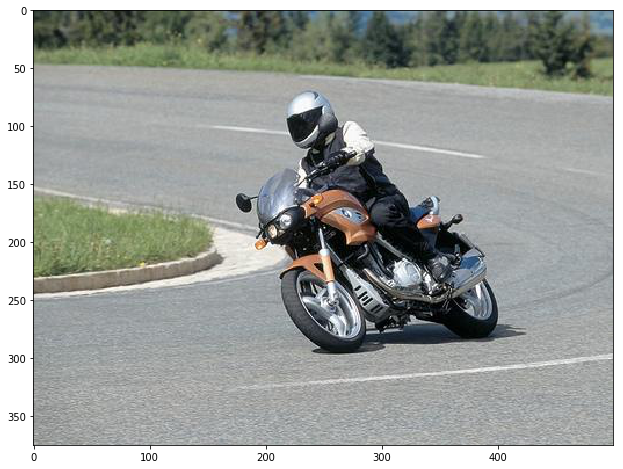

In [3]:
img = sku.img_as_float(skio.imread("moto.jpg"))
plt.imshow(img);

In [4]:
import skimage.segmentation as seg

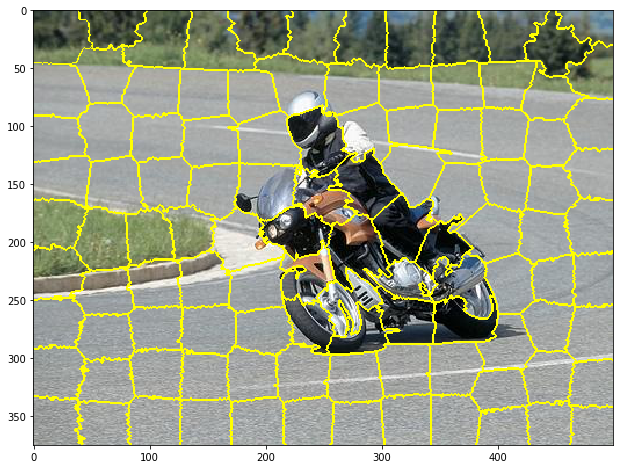

In [5]:
sps = seg.slic(img, slic_zero=True)
plt.imshow(seg.mark_boundaries(img, sps));

In [6]:
from skimage.future import graph
import skimage.filters as skf
import skimage.color as skc

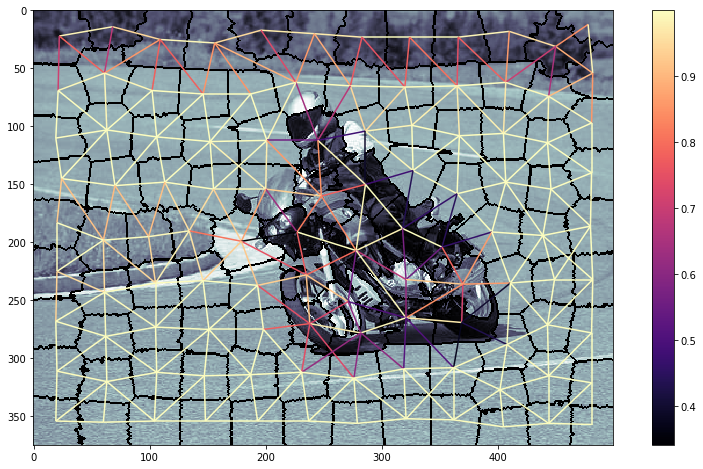

In [7]:
rag = graph.rag_mean_color(img, sps, mode='similarity', sigma=1.)
lc = graph.show_rag(sps, rag, img)
cbar = plt.colorbar(lc);

In [8]:
def hufbauer_alpha(image, labels, connectivity=2, fudge=1e-8):
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'pixel count': 0,
                            'total color': np.array([0, 0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['pixel count'] += 1
        rag.node[current]['total color'] += image[index]

    for n in rag:
        rag.node[n]['mean color'] = (rag.node[n]['total color'] /
                                     rag.node[n]['pixel count'])
        rag.node[n]['alpha'] = np.sum(rag.node[n]['mean color'] ** 2)

    for x, y, d in rag.edges(data=True):
        d['weight'] = -1 / (fudge + (rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2)
        #d['weight'] = (rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2.
        #d['weight'] = np.log((rag.node[x]['alpha'] - rag.node[y]['alpha']) ** 2.)

    return rag

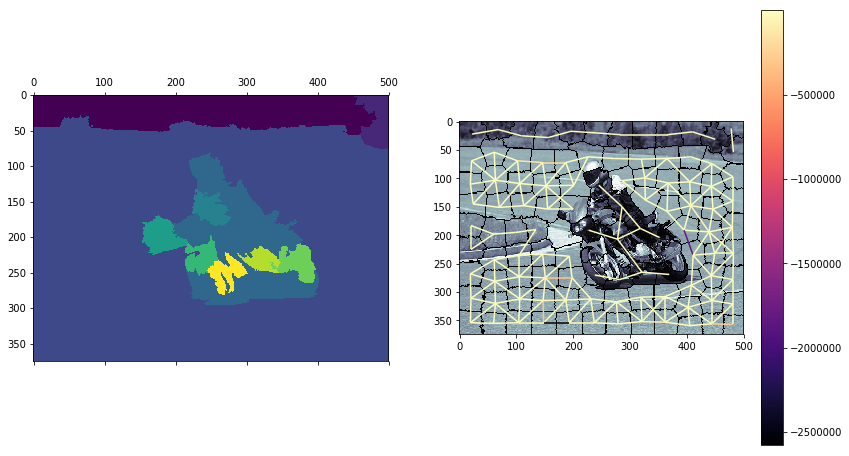

In [9]:
rag_a = hufbauer_alpha(img, sps, fudge=1e-8)
sps_a = graph.cut_threshold(sps, rag_a, -10)

fig, (left, right) = plt.subplots(1, 2)

#left.imshow(seg.mark_boundaries(img, sps_a));
left.matshow(sps_a)
lc = graph.show_rag(sps, rag_a, img, ax=right);
cbar = fig.colorbar(lc);

In [10]:
def hufbauer_beta(image, labels, connectivity=2):
    image = skc.rgb2lab(image)[:, :, [1,2]]
    rag = graph.RAG(labels, connectivity=connectivity)

    for n in rag:
        rag.node[n].update({'labels': [n],
                            'pixel count': 0,
                            'total hue': np.array([0, 0],
                                                    dtype=np.double)})

    for index in np.ndindex(labels.shape):
        current = labels[index]
        rag.node[current]['pixel count'] += 1
        rag.node[current]['total hue'] += image[index]

    for n in rag:
        rag.node[n]['mean hue'] = (rag.node[n]['total hue'] /
                                     rag.node[n]['pixel count'])

    for x, y, d in rag.edges(data=True):
        diff = rag.node[x]['mean hue'] - rag.node[y]['mean hue']
        diff = np.linalg.norm(diff)
        d['weight'] = diff

    return rag

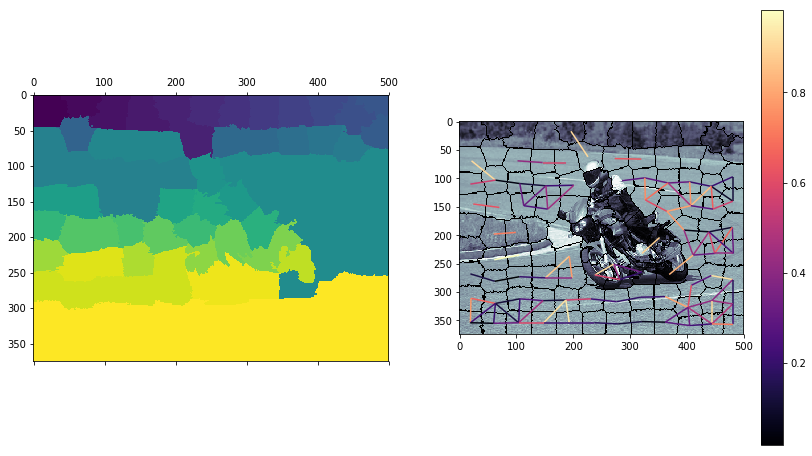

In [17]:
rag_b = hufbauer_beta(img, sps)
sps_b = graph.cut_threshold(sps, rag_b, 1)

fig, (left, right) = plt.subplots(1, 2)

#left.imshow(seg.mark_boundaries(img, sps_b));
left.matshow(sps_b)
lc = graph.show_rag(sps, rag_b, img, ax=right);
cbar = fig.colorbar(lc);

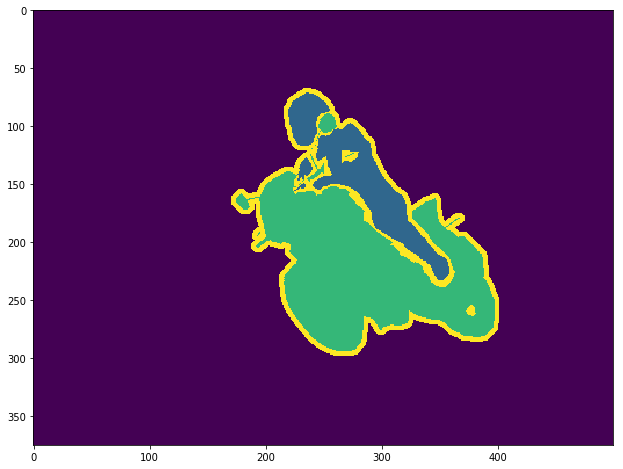

In [12]:
seg_orig = skio.imread("moto_seg.png")
_, true_seg = np.unique(seg_orig.reshape(-1, 3), axis=0, return_inverse=True)
true_seg = true_seg.reshape(seg_orig.shape[:2])
plt.imshow(true_seg)

In [13]:
from sklearn.metrics import adjusted_rand_score

In [14]:
rag_a = hufbauer_alpha(img, sps)
rag_b = hufbauer_beta(img, sps)

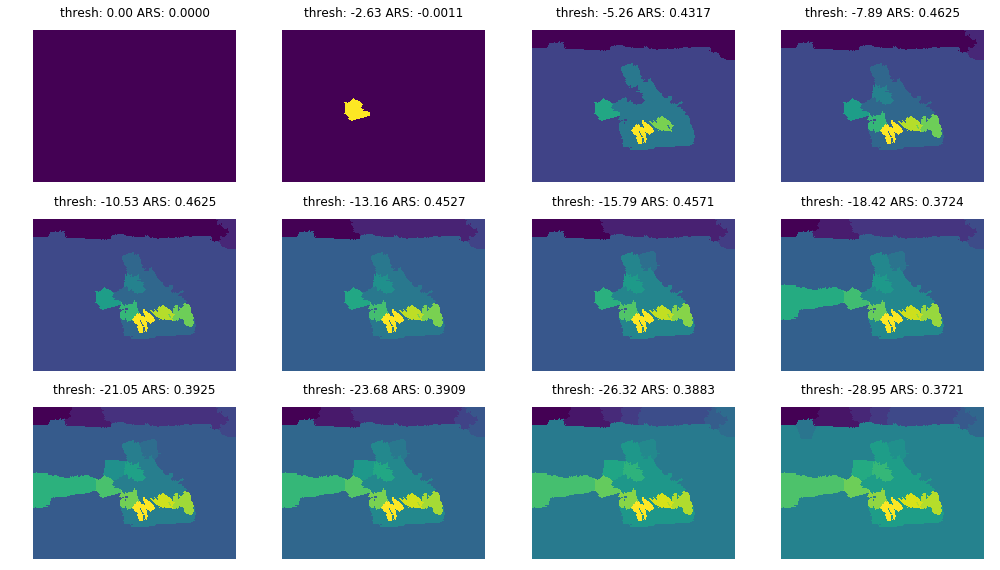

In [15]:
alpha_thresh = np.linspace(0, -50, 20)
alphas = [
    graph.cut_threshold(sps, rag_a, thresh, in_place=False)
    for thresh in alpha_thresh
]

_, axs = plt.subplots(3, 4)
for thresh, alpha, ax in zip(alpha_thresh, alphas, axs.flat):
    score = adjusted_rand_score(true_seg.flat, alpha.flat)
    ax.matshow(alpha)
    ax.set_axis_off()
    ax.set_title("thresh: {:.2f} ARS: {:.4f}".format(thresh, score))
plt.tight_layout();

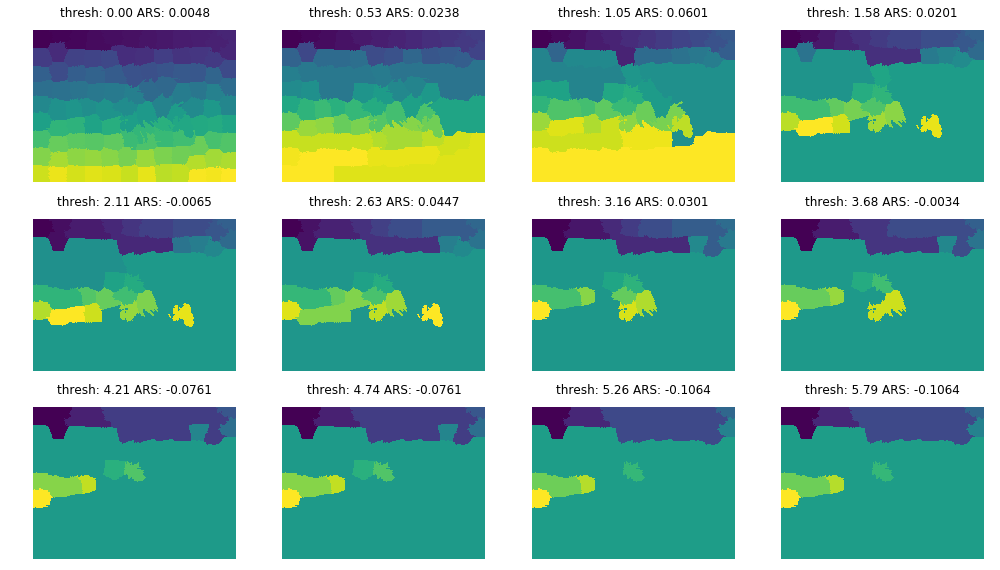

In [16]:
beta_thresh = np.linspace(0, 10, 20)
betas = [
    graph.cut_threshold(sps, rag_b, thresh, in_place=False)
    for thresh in beta_thresh
]

_, axs = plt.subplots(3, 4)
for thresh, beta, ax in zip(beta_thresh, betas, axs.flat):
    score = adjusted_rand_score(true_seg.flat, beta.flat)
    ax.matshow(beta)
    ax.set_axis_off()
    ax.set_title("thresh: {:.2f} ARS: {:.4f}".format(thresh, score))
plt.tight_layout();